<!DOCTYPE html>
<html>
    <body>
        <h3>Descriptions of files:</h3>
        <ol>
            <li>Stores.csv: Contains the anonyised information aout the 45 stores, indicating the type and size of store</li>
            <li>Train.csv: This is the historical training sata which covers to 2010-02-05 TO 2012-11-01. Within this file you will find the following fields:</li>
            <ul>
                <li>Store- The store number</li>
                <li>Dept - THE Department Number</li>
                <li>Date - The week</li>
                <li>Weekly Sales - Sales for the given department in the given store</li>
                <li>IsHoliday - Whether the week is a special holiday week</li>
            </ul>
            <li>Test.csv - This is identical to the train.csv except the weekly sales have been witheld</li>
            <li>features.csv- The file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields</li>
                <ul>
                    <li>Store- The store number</li>
                    <li>Date - The week</li>
                    <li>Temperature - Average temperature in the region</li>
                    <li>Fuel_Price - Cost of fuel in the region</li>
                    <li>Markdown1-5 - Anonymised data related to promotional markdowns that Walmart is running. Markdown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA</li>
                    <li>CPI - the consumer price index</li>
                    <li>Unemployment - The unemployment rate</li>
                    <li>IsHoliday - Whether the week is a special holiday week</li>
                </ul>
        </ol>
<p>For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):</p>
<ul>
    <li>SuperBowl: 12-02-2010, 11-02-2011, 10-02-2012, 8-02-2013</li>
    <li>Labour Day: 10-09-2010, 9-09-2011, 7-09-2012, 6-09-2013,</li>
    <li>Thanksgiving: 26-11-2010, 25-11-2011, 23-11-2012, 20-11-2013</li>
    <li>Christmas: 31-12-2010, 30-12-2011, 28-12-2012, 27-12-2013</li>
</ul>

<hr>
<p>
<b>Evaluation Metric:</b> Weighted Mean Absolute Error (WMAE)
    <b><pre style = 'text-align:center'>1/wi * sum(wi|yi - ^y|)</pre></b>
where wi are weights, w=5 if the week is a holiday week, 1 otherwise.
</p>
</body>
</html>

In [1]:
path = "C:/Machine_learning_datafiles/kaggle/Walmart_recruiting_store_sales"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scipy_stats
import missingno as msno

In [4]:
os.chdir(path)

In [5]:
def randomColors():
    color_list = ['A', 'B', 'C', 'D', 'E', 'F'] + [i for i in range(10)]
    color = '#'+''.join(np.random.choice(color_list, 6, replace=False))
    return color

In [6]:
train = pd.read_csv('train.csv', parse_dates=['Date'])
test = pd.read_csv('test.csv', parse_dates=['Date'])
subfile = pd.read_csv('sampleSubmission.csv')
features = pd.read_csv('features.csv', parse_dates = ['Date'])
stores = pd.read_csv('stores.csv')

In [7]:
pd.set_option("display.max_columns", 200)
plt.style.use('bmh')
%matplotlib inline

In [8]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [10]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [11]:
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


**MERGING FILES**

In [12]:
train_data = train.copy()
test_data = test.copy()

In [13]:
#merging stores data
train_data = train_data.merge(stores, on=['Store'], how='left')
test_data = test_data.merge(stores, on=['Store'], how='left')

In [14]:
train_data.columns.intersection(features.columns)

Index(['Store', 'Date', 'IsHoliday'], dtype='object')

In [15]:
#merging features data
train_data = train_data.merge(features, on=train_data.columns.intersection(features.columns).tolist(), how='left')
test_data = test_data.merge(features, on=test_data.columns.intersection(features.columns).tolist(), how='left')

In [16]:
train_data.shape, test_data.shape

((421570, 16), (115064, 15))

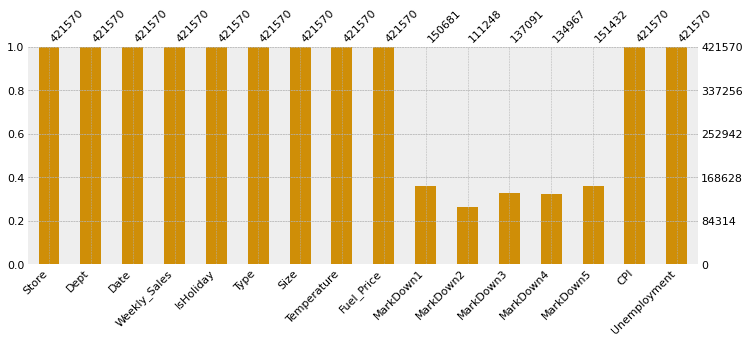

In [17]:
msno.bar(train_data, figsize=(12,4), fontsize=11, color=randomColors());

`In the train set, Markdowns 1-5 have lots of missing values`

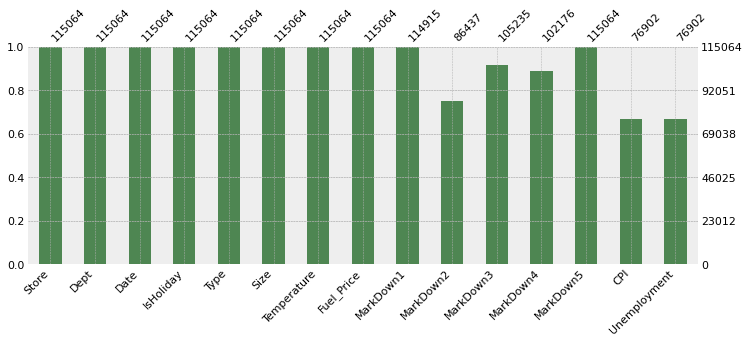

In [18]:
msno.bar(test_data, figsize=(12,4), fontsize=11, color=randomColors());

`In the Test data Markdowns 1-4 as well a CPI and Unemployment all have missing values`

In [19]:
train_data['week'] = train_data.Date.dt.week
test_data['week'] = test_data.Date.dt.week
train_data['month'] = train_data.Date.dt.month
test_data['month'] = test_data.Date.dt.month
train_data['year'] = train_data.Date.dt.year
test_data['year'] = test_data.Date.dt.year

**`UNIVARIATE ANALYSIS`**

`Weekly sales for Walmart in all stores`

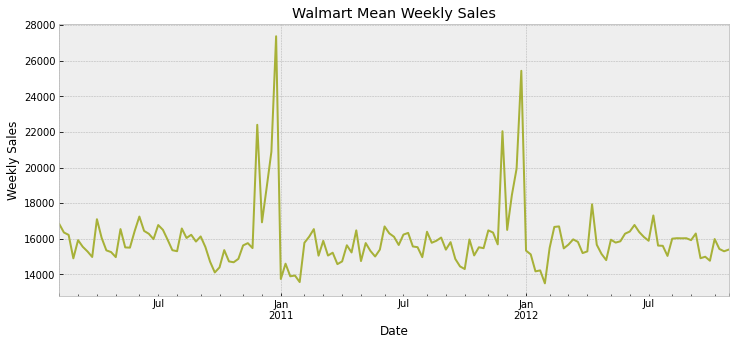

In [20]:
train_data.set_index('Date').resample('1W').Weekly_Sales.mean().plot(
    figsize=(12,5), color=randomColors(), title='Walmart Mean Weekly Sales', ylabel='Weekly Sales');

**`Sales are usually higher from November till December in all years (2011-2012). Year 2013 doesn't contain data up to November`**

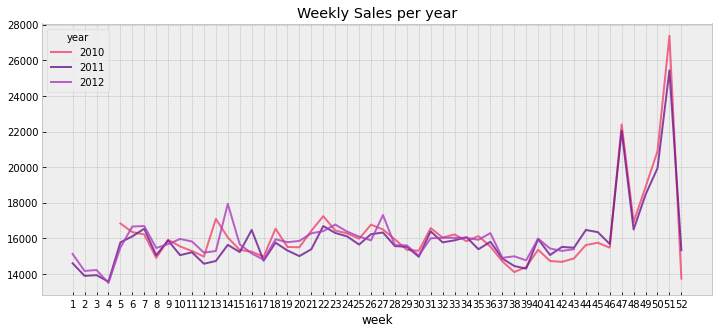

In [21]:
train_data.groupby(['year','week']).Weekly_Sales.mean().unstack(0).plot(
    figsize=(12,5), xticks=np.arange(1,53, 1), color=[randomColors() for i in range(3)], alpha=0.8, 
    title='Weekly Sales per year');

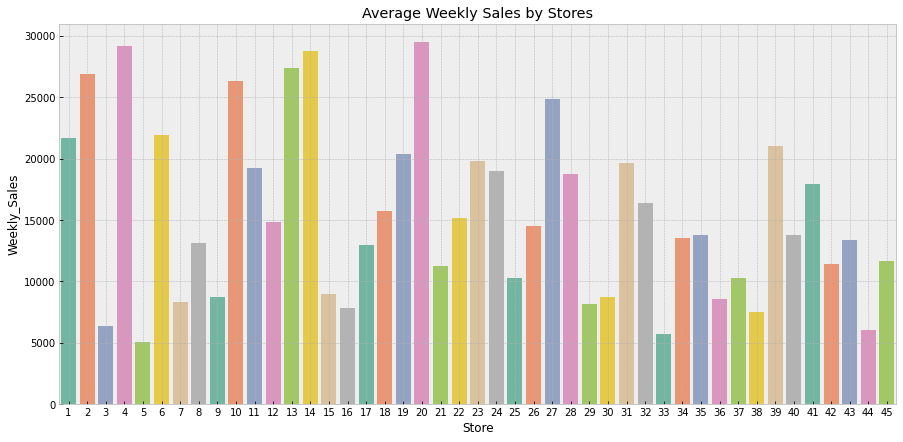

In [22]:
plt.figure(figsize=(15,7))
sns.barplot('Store', 'Weekly_Sales', data=train_data,ci=None, palette='Set2')
plt.title('Average Weekly Sales by Stores')
plt.grid(True);

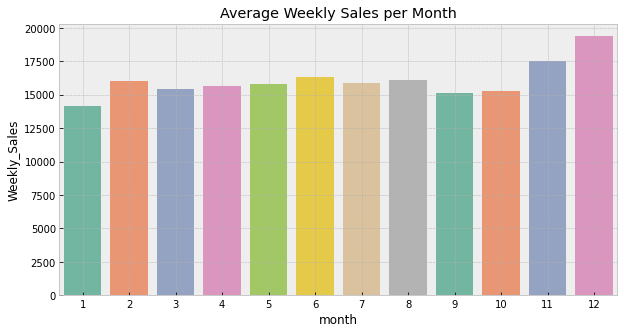

In [23]:
plt.figure(figsize=(10,5))
sns.barplot('month', 'Weekly_Sales', data=train_data,ci=None, palette='Set2')
plt.title('Average Weekly Sales per Month')
plt.grid(True);

`Sales are Higher from November till December`

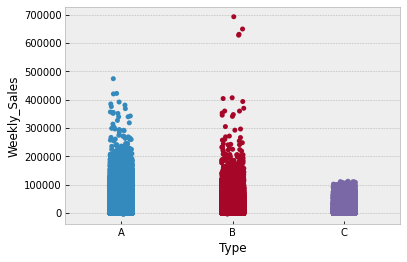

In [24]:
sns.stripplot('Type', 'Weekly_Sales', data=train_data);

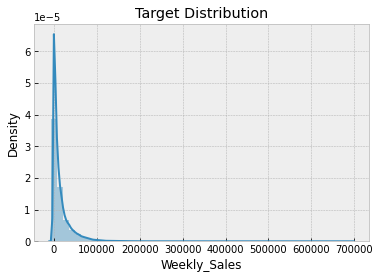

In [25]:
sns.distplot(train_data.Weekly_Sales)
plt.title('Target Distribution');

In [26]:
train_data.Weekly_Sales.apply(['min','mean','median','max','skew', 'kurtosis'])

min          -4988.940000
mean         15981.258123
median        7612.030000
max         693099.360000
skew             3.262008
kurtosis        21.491290
Name: Weekly_Sales, dtype: float64

In [27]:
(train_data.Weekly_Sales < 0).sum()

1285

`There are 1285 losses recorded`

**`The weekly sales has some negative values. This isn't supposed to be so as sales cannot be negative. So we could remove them or replace them as "No Sales".`**

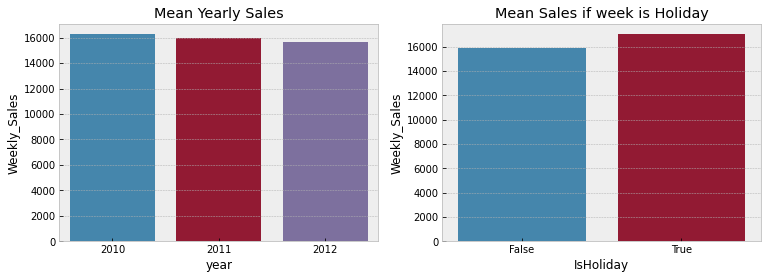

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot('year', 'Weekly_Sales', data=train_data, ci=None)
plt.title('Mean Yearly Sales')
plt.subplot(122)
sns.barplot('IsHoliday', 'Weekly_Sales', data=train_data, ci=None)
plt.title('Mean Sales if week is Holiday')
plt.subplots_adjust(right=1.1);

`Sales are usually higher when the week is a holiday`. <br>`The number of sales per year is comparably the same`

In [29]:
def season(x):
    if x in [3,4,5]: return 'Spring'
    elif x in [6,7,8]: return 'Summer'
    elif x in [9,10,11]: return 'Autumn'
    else: return 'Winter'

In [30]:
season_map = {'Winter' : 0, 'Spring' :1, 'Summer' : 3, 'Autumn':4}
train_data['Season'] = train_data.month.map(season)
test_data['Season'] = test_data.month.map(season)

**`BIVARIATE ANAYSIS.`**

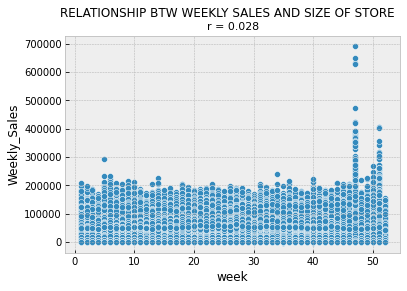

In [31]:
sns.scatterplot('week', 'Weekly_Sales', data=train_data)
plt.title('r = {}'.format(scipy_stats.pearsonr(train_data.week, train_data.Weekly_Sales)[0].round(3)), fontsize=11)
plt.suptitle('RELATIONSHIP BTW WEEKLY SALES AND SIZE OF STORE');

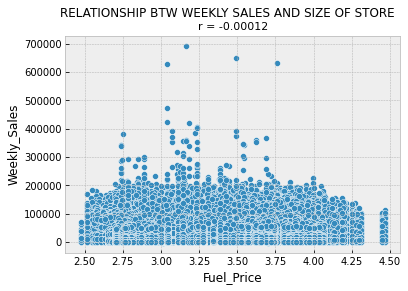

In [32]:
sns.scatterplot('Fuel_Price', 'Weekly_Sales', data=train_data)
plt.title('r = {}'.format(scipy_stats.pearsonr(train_data.Fuel_Price, train_data.Weekly_Sales)[0].round(5)), fontsize=11)
plt.suptitle('RELATIONSHIP BTW WEEKLY SALES AND SIZE OF STORE');

Relationship btw Weekly Sales and Promotional Markdowns

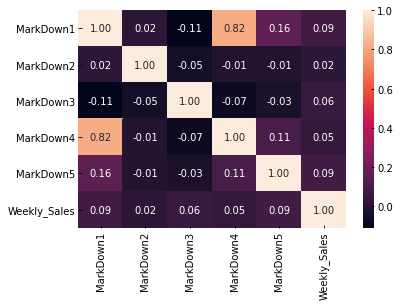

In [33]:
sns.heatmap(train_data.filter(like='Mark').join(train_data.Weekly_Sales).corr(), annot=True, fmt='.2f');

In [34]:
d = train_data[['Store', 'Size']].join(train_data.Type).join(train_data.Weekly_Sales).join(train_data.Dept)
d.Type = d.Type.factorize(sort=True)[0]

In [35]:
d.corr()

,Store,Size,Type,Weekly_Sales,Dept
Store,1.000000,-0.182881,0.226410,-0.085195,0.024004
Size,-0.182881,1.000000,-0.811593,0.243828,-0.002966
Type,0.226410,-0.811593,1.000000,-0.182242,0.003708
Weekly_Sales,-0.085195,0.243828,-0.182242,1.000000,0.148032
Dept,0.024004,-0.002966,0.003708,0.148032,1.000000


`There is a strong negative relationship btw the Type of Store and the Size of the store. It is more appropriate to treat "Type" as an ordinal feature. We could as well drop one of them.`

In [36]:
train_data[['CPI', 'Temperature', 'Fuel_Price', 'Weekly_Sales', 'Unemployment',
            'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].corr()

,CPI,Temperature,Fuel_Price,Weekly_Sales,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
CPI,1.000000,0.182112,-0.164210,-0.020921,-0.299953,-0.055558,-0.039534,-0.023590,-0.049628,0.060630
Temperature,0.182112,1.000000,0.143859,-0.002312,0.096730,-0.040594,-0.323927,-0.096880,-0.063947,-0.017544
Fuel_Price,-0.164210,0.143859,1.000000,-0.000120,-0.033853,0.061371,-0.220895,-0.102092,-0.044986,-0.128065
Weekly_Sales,-0.020921,-0.002312,-0.000120,1.000000,-0.025864,0.085251,0.024130,0.060385,0.045414,0.090362
Unemployment,-0.299953,0.096730,-0.033853,-0.025864,1.000000,0.050285,0.020940,0.012818,0.024963,-0.003843
MarkDown1,-0.055558,-0.040594,0.061371,0.085251,0.050285,1.000000,0.024486,-0.108115,0.819238,0.160257
MarkDown2,-0.039534,-0.323927,-0.220895,0.024130,0.020940,0.024486,1.000000,-0.050108,-0.007768,-0.007440
MarkDown3,-0.023590,-0.096880,-0.102092,0.060385,0.012818,-0.108115,-0.050108,1.000000,-0.071095,-0.026467
MarkDown4,-0.049628,-0.063947,-0.044986,0.045414,0.024963,0.819238,-0.007768,-0.071095,1.000000,0.107792
MarkDown5,0.060630,-0.017544,-0.128065,0.090362,-0.003843,0.160257,-0.007440,-0.026467,0.107792,1.000000


`Data Cleaning`

In [37]:
df = train_data.append(test_data)[train_data.columns]

In [38]:
df.IsHoliday = df.IsHoliday * 1
df.Type = df.Type.map({'A' : 3, 'B':2, 'C': 1})
df.Season = df.Season.factorize(sort=True)[0]

In [39]:
df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = df[[
    'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].replace({np.nan : 0})

In [40]:
store_cpi = df.groupby('Store').CPI.mean()
store_unemploy = df.groupby('Store').Unemployment.mean()

`Replacing missing CPI and UNemployment with the mean values. Firstly, we would replace them with their respective stores and map them with the store_cpi`

In [41]:
df.loc[df.CPI.isna(), 'CPI'] = df.loc[df.CPI.isna(), 'Store'].map(store_cpi)
df.loc[df.Unemployment.isna(), 'Unemployment'] = df.loc[df.Unemployment.isna(), 'Store'].map(store_unemploy)

`REPRESENTING NEGATIVE SALES AS ZERO SALES`

In [42]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int32
Type                     int64
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
week                     int64
month                    int64
year                     int64
Season                   int64
dtype: object

In [45]:
df.loc[df.Weekly_Sales < 0, 'Weekly_Sales'] = 0

**`SPLITTING BACK TO TRAIN AND TEST DATA`**

In [49]:
train_data = df[df.Weekly_Sales.notnull()]
test_data = df[df.Weekly_Sales.isnull()].drop('Weekly_Sales', 1)

`SAVING DATASETS`

In [50]:
#saving cleaned dataset
train_data.to_pickle('Train_cleaned.pkl', compression='zip')
test_data.to_pickle('Test_cleaned.pkl', compression='zip')

In [51]:
gc.collect()

160

In [52]:
train_data.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,year,Season
0,1,1,2010-02-05,24924.50,0,3,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010,3
1,1,1,2010-02-12,46039.49,1,3,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,6,2,2010,3
2,1,1,2010-02-19,41595.55,0,3,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,7,2,2010,3


In [53]:
train_data.shape, test_data.shape

((421570, 20), (115064, 19))